Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "João Antonio Oliveira Pedrosa"
COLLABORATORS = ""

---

# Lista 03 - ICs + Bootstrap


**Objetivos de Aprendizado**
- Saber computar intervalos de confiança (clássico e via bootstrap)
- Saber realizar testes a/b

In [2]:
# -*- coding: utf 8


from matplotlib import pyplot as plt


from numpy.testing import assert_array_equal
from numpy.testing import assert_array_almost_equal
from numpy.testing import assert_equal
from numpy.testing import assert_almost_equal


import pandas as pd
import numpy as np


plt.style.use('seaborn-colorblind')
plt.ion()

## Introdução

O objetivo deste notebook é realizar uma introdução ao conceito de intervalos de confiança. Para tal, vamos explorar a base de dados do Enem 2015. A base é composta das seguintes colunas:

- DEPENDENCIA_ADMINISTRATIVA: Indicando o tipo da escola `{'Estadual', 'Federal', 'Municipal', 'Privada'}`
- NOTA_MEDIA_ESCOLA: Qual a nota média da escola no Enem
- TAXA_DE_APROVACAO: Quantos foram aprovados [0, 100]
- TAXA_DE_PARTICIPACAO: Quantos participaram da prova [0, 100]

Abaixo temos o código que faz a leitura dos dados.

In [3]:
df = pd.read_csv('enem2015.csv')
df.head()

,DEPENDENCIA_ADMINISTRATIVA,NOTA_MEDIA_ESCOLA,TAXA_DE_APROVACAO,TAXA_DE_PARTICIPACAO
0,Federal,659.258362,92.2,96.894409
1,Federal,637.646728,86.5,98.717949
2,Estadual,556.710632,82.5,74.603180
3,Estadual,542.865967,70.2,54.651165
4,Estadual,557.379150,67.0,64.864861


Vamos dar uma olhada nos dados

In [4]:
df.describe()

,NOTA_MEDIA_ESCOLA,TAXA_DE_APROVACAO,TAXA_DE_PARTICIPACAO
count,1685.000000,1683.000000,1685.000000
mean,575.391745,86.044444,75.263669
std,40.796223,10.334011,16.886193
min,487.007141,47.700000,50.000000
25%,544.937500,79.500000,59.615387
50%,561.520752,87.800000,72.916672
75%,607.530579,94.550000,92.857140
max,713.629028,100.000000,100.000000


## Exercício 01

Para entender os dados, vamos iniciar com um pequenos histograma que será utilizado para entender a distribuição das médias das escolas.

A) Plote um histograma dos dados da coluna "NOTA_MEDIA_ESCOLA".

Sua resposta deve parecer com a figura abaixo

![](./saida1.png)

[]

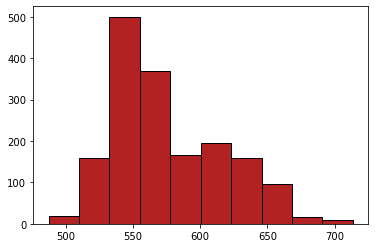

In [5]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import math

nota_m = df["NOTA_MEDIA_ESCOLA"]
nota_m = np.array([x for x in nota_m if not math.isnan(x)])

x, bins = np.histogram(nota_m)

plt.hist(nota_m, edgecolor = "black", color = "firebrick", bins = bins)
plt.plot()

B) Agora, plote uma CDF da coluna 'TAXA_DE_APROVACAO'. 

Sua resposta deve parecer com a figura abaixo

![](./saida2.png)

**Use o statsmodels e crie um objeto `ecdf = ECDF(...)`.**

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF

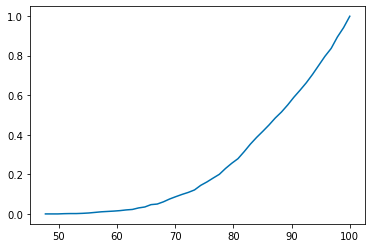

In [7]:
ap_rate = df["TAXA_DE_APROVACAO"]
# ap_rate = np.array([x for x in ap_rate if not math.isnan(x)])
ecdf = ECDF(ap_rate)
x = np.linspace(ap_rate.min(), ap_rate.max())
y = ecdf(x)
plt.plot(x, y)

C) Para o valor médio das notas as escolas, determine com 95% o intervalo de confiança. **Não utilize a técnica de bootstrap.**

Lembrando do conceito visto em aula:

$$\begin{align}
0.95 = P(-z \le Z \le z)=P \left(-1.96 \le \frac {\bar X-\mu}{\sigma/\sqrt{n}} \le 1.96 \right) = P \left( \bar X - 1.96 \frac \sigma {\sqrt{n}} \le \mu \le \bar X + 1.96 \frac \sigma {\sqrt{n}}\right).
\end{align}$$

Neste exercício você deverá retornar uma lista com os valores inferior e superior do intervalo de confiança.

In [8]:
def calcula_IC_notas(df):
    import scipy.stats as ss
    from statistics import variance
    
    nota_m = np.array(df["NOTA_MEDIA_ESCOLA"])
    n      = len(nota_m)
    mu     = np.mean(nota_m)
    sigma  = math.sqrt(variance(nota_m)) / np.sqrt(n)
    
    inferior = mu - 1.96*sigma
    superior = mu + 1.96*sigma
    
    return [inferior, superior]

calcula_IC_notas(df)

[573.4438030115773, 577.3396875055739]

Para certificar que a sua função está retornando o intervalo correto, verifique se os valores abaixo 
são os mesmos para a sua função:
    
[573.4438030115773, 577.3396875055739]

Se eles não estiverem neste intervalo, qual pode ser o motivo ?

Verifique os parâmetros da função _np.std()_

C) Na função abaixo, retorne o número da opção que melhor define o que indica o Intervalo de Confiança:

    1: Caso o experimento seja repetido, com 95% de chance a média vai estar no intervalo
    2: 5% da amostra está a mais que 1.96 de distância da média da população
    3: 95% dos valores da população estão dentro do intervalo
    4: A média da amostra está com 95% de probabilidade dentro do intervalo
    5: Nenhuma das anteriores

In [9]:
def resposta():
    return 1

## Exercício 02

Agora vamos calcular intervalos de confiança utilizando **bootstrap**. 

A) Utilizando o mesmo atributo do exercício anterior, execute um bootstrap com 5000 amostras.

Lembre do conceito visto em aula:

"Para implementar o Bootstrap, vamos implementar uma função. A mesma faz uso da função _sample_ de pandas que gera uma amostra aleatória de _n_ elementos retirados do dataframe."

1. Dado _n_ e _size_
2. Gere _n_ amostras de tamanho _size_ com reposição
3. Tira a média
4. Retorne as novas amostras e veja a distribuição das mesmas

Assim como o intervalo anterior, estamos gerando um bootstrap da média. Observe que temos uma resposta similar a de antes. Afinal, o Bootstrap aproxima o IC clássico. Em contrapartida, um fator importante do Bootstrap é que o mesmo permite o uso de outras medidas centrais (como a mediana).

In [10]:
nme = df['NOTA_MEDIA_ESCOLA']
N = 5000

def bootstrap_mean(nme, n):
    values = np.zeros(n)
    for i in range(n):
        sample    = nme.sample(len(nme), replace = True)
        values[i] = sample.mean()
    return values

B) Plote a distribuição das médias amostrais.

Sua saída deve ser parecida com a figura abaixo.

![](./saida3.png)

[]

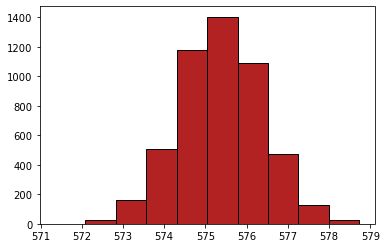

In [11]:
bm_values = bootstrap_mean(nme, N)
_, bins = np.histogram(bm_values)

plt.hist(bm_values, edgecolor = "black", color = "firebrick", bins = bins)
plt.plot()

C) Faça uma função que indique onde ficam 95% dos dados sintéticos

In [12]:
def percentile(bm_values, init, final):
#     bm_values = np.sort(bm_values)
#     per1      = int(len(bm_values) / 100 * init)
#     per2      = int(len(bm_values) / 100 * final)
#     inferior  = bm_values[per1]
#     superior  = bm_values[per2]
    inferior = np.percentile(bm_values, init)
    superior = np.percentile(bm_values, final)
    return [inferior, superior]

Na célula abaixo chame a função que você definiu acima. Altere os parâmetros _init_ e _final_ 
para que a resposta indique os 95%. 

In [1]:
bm_values = bootstrap_mean(nme, N)
percentile(bm_values, 2.5)

NameError: name 'bootstrap_mean' is not defined

## Exercício 03

Agora vamos juntar tudo fazendo uso de Testes A/B. Para tal, vamos separar as escolas em dois grupos: privadas e não privadas. Crie dois dataframes com as escolas privadas e não privadas.

In [14]:
df_privada = df[df["DEPENDENCIA_ADMINISTRATIVA"] == "Privada"]
df_nao_privada = df[df["DEPENDENCIA_ADMINISTRATIVA"] != "Privada"]

A) Realize um Teste A/B para indicar qual tipo de escola tem a média maior. Você pode fazer tal teste via Bootstrap ou Valor Exato. Para realizar tal teste criamos um esqueleto de função abaixo, o mesmo vai receber dois dataframes:

`df_hyp_menor` (o grupo que achamos ser menor em média) e `df_hyp_maior` (o grupo que achamos ser maior em média)

Seu método deve retornar `True` caso tenha evidências estatísticas de que o `df_hyp_menor` seja realmente menor. Para tal, compare os intervalos de confiança.

Para lhe ajudar, compare os ICs abaixo. Qual seria a resposta? `True` ou `False`?

In [15]:
calcula_IC_notas(df_privada)

[617.0927970876667, 621.8437919155135]

In [16]:
calcula_IC_notas(df_nao_privada)

[551.6553806622885, 554.539500611706]

In [17]:
def teste_ab(df_hyp_menor, df_hyp_maior):
    ic_inf_menor, ic_sup_menor = calcula_IC_notas(df_hyp_menor)
    ic_inf_maior, ic_sup_maior = calcula_IC_notas(df_hyp_maior)
    if ic_sup_menor < ic_inf_maior: return True
    else: return False

In [18]:
print(teste_ab(df_nao_privada, df_privada)) # True
print(teste_ab(df_privada, df_nao_privada)) # False

True
False


B) Repita o teste comparando as escolas Privadas com as Federais. Pense um pouco qual a conclusão.

In [19]:
df_fed = df[df["DEPENDENCIA_ADMINISTRATIVA"] == "Federal"]
print(teste_ab(df_privada, df_fed))
print(teste_ab(df_fed, df_privada))

False
False


C) Agora, faça um outro teste A/B com a **fração de escolas cuja taxa de aprendizado seja superior a 90%**. Note que isto não é uma média. Isto é: `1 - ecdf(90)`, onde `ecdf` é um objeto da class ECDF do statsmodels. Tal CDF foi computada na coluna `TAXA_DE_APROVACAO`.

Para fazer esta tarefa você deve implementar duas funções. 

1. A primeira computa um IC (com significância de 5%, ou em outras palaras um IC de 95%) do valor acima. Tal IC deve ser feito via bootstrap.
1. Uma outra função que compara os dois grupos

In [50]:
def ic_bootstrap_ccdf(dfa, n, taxa=90):
    values = np.zeros(n)
    for i in range(n):
        sample    = dfa.sample(len(dfa), replace = True)
        values[i] = len(sample[sample["TAXA_DE_APROVACAO"] > taxa])/len(sample)
    return values

def teste_ab_ccdf(df_hyp_menor, df_hyp_maior, n=5000, taxa=90):
    val_menor = ic_bootstrap_ccdf(df_hyp_menor, n, taxa)
    val_maior = ic_bootstrap_ccdf(df_hyp_maior, n, taxa)
    ic_inf_menor, ic_sup_menor = percentile(val_menor, 2.5, 97.5)
    ic_inf_maior, ic_sup_maior = percentile(val_maior, 2.5, 97.5)
    
    if ic_sup_menor < ic_inf_maior:
        return True
    else:
        return False

In [51]:
teste_ab_ccdf(df_privada, df_fed)

False

**Interprete os resultados. Observe que em um caso o teste falha no outro não!**

No caso do meu teste, ambos deram falso. A minha interpretação caso um tivesse falhado e outro não, seria que, apesar de não existir uma diferença significante nas médias das notas de escolas privadas e federais, eu posso afirmar, com 95% de certeza, que o conjunto das escolas federais, tem uma fração significantemente maior de escolas com taxa de aprovação maior do que 90%.